In [1]:
from sqlalchemy import create_engine
from scipy import stats
import statistics as s
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mp
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
IBGEFILE_UNITS = pd.read_csv("data\IBGEFILE.UNITS.csv")

In [3]:
BGEIDSC_EF2EFFP = pd.read_csv("data\BGEIDSC.EF2EFFP.csv")

In [4]:
BGETCHDATA_PTCHTRANH = pd.read_csv("data\BGETCHDATA.PTCHTRANH.csv")

In [5]:
Extranet2_ExactFuelEvents = pd.read_csv("data\Extranet2.ExactFuelEvents.csv")

In [6]:
Extranet2_ExactFuelTankLevels = pd.read_csv("data\Extranet2.ExactFuelTankLevels.csv")

In [7]:
df_vehicle = IBGEFILE_UNITS

In [8]:
df_levels = Extranet2_ExactFuelTankLevels[['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']]

In [9]:
df_events = Extranet2_ExactFuelEvents[['Id', 'EventTimeStamp', 'EquipmentID','DriverID', 'Latitude', 'Longitude','Speed',
                          'Heading', 'Odometer', 'IgnitionStatus','EFReportReason']]

In [10]:
df_optimization = BGEIDSC_EF2EFFP[['TRUCK', 'TANKCAP']]

In [11]:
df_transaction = BGETCHDATA_PTCHTRANH[['TRNID', 'TRNDAT', 'TRNTIM', 'TRNTS#','TRNDRI', 'TRNUNT', 'TRNPI1', 'TRNPQ1']]

In [12]:
df_transaction = df_transaction[~df_transaction['TRNPI1'].isin(['SCLE', 'CADV', 'DEFD', 'ADD ', 'OIL ', 'UREA', 'DEFC'])] 

## Cast keys to common data type 

In [13]:
df_transaction['TRNUNT'] = df_transaction['TRNUNT'].astype(str);
df_optimization['TRUCK'] = df_optimization['TRUCK'].astype(str);
df_events['Id'] = df_events['Id'].astype(str);
df_levels['ExactFuelEventId'] = df_levels['ExactFuelEventId'].astype(str);
df_events['EquipmentID'] = df_events['EquipmentID'].astype(str);

## Clean column values


In [14]:
df_transaction['TRNUNT'] = df_transaction['TRNUNT'].apply(lambda x: x.strip()).replace('', np.nan);
df_optimization['TRUCK'] = df_optimization['TRUCK'].apply(lambda x: x.strip()).replace('', np.nan);
df_events['Id'] = df_events['Id'].apply(lambda x: x.strip()).replace('', np.nan);
df_levels['ExactFuelEventId'] = df_levels['ExactFuelEventId'].apply(lambda x: x.strip()).replace('', np.nan);
df_events['EquipmentID'] = df_events['EquipmentID'].apply(lambda x: x.strip()).replace('', np.nan);

## Merge Dfs together

In [72]:
#A = pd.merge(df_transaction, df_vehicle, how='inner', left_on='TRNUNT', right_on = 'UNUNIT')
#A.head(5)

In [73]:
#B = pd.merge(A, df_optimization, how = 'inner', left_on = 'UNUNIT', right_on = 'TRUCK')
#B.head(5)

In [74]:
#C = pd.merge(df_events_30, df_event_level, how='inner', left_on='Id', right_on = 'ExactFuelEventId')
#C.head(5)

In [72]:
df_event_level = pd.merge(df_events, df_levels, how='inner', left_on='Id', right_on = 'ExactFuelEventId')

In [77]:
##Remove drivers not likely to be thieves 
df_event_level =  df_event_level[~df_event_level['DriverID'].isin(['SMID', 'BEVL', 'RICS', 'NEWR ', 'MARC ', 'LOVH', 'nan', '36728'])] 

#Clean DriverID column to prepare for Harmonic Mean calculation 
df_event_level['DriverID'] = df_event_level['DriverID'].astype(str); 
df_event_level['DriverID'] = df_event_level['DriverID'].apply(lambda x: x.strip()).replace('', np.nan);

## Calculate Harmonic Mean Per DriverID (Max, Median, Min Frequencies) 

In [84]:
from collections import Counter 
drivers = Counter(df_event_level['DriverID'])
drivers = pd.DataFrame(list(drivers.items()), columns=['DriverID', 'Frequency'])
drivers = drivers.sort_values(by='Frequency', ascending=False)
#drivers.dtypes
drivers_is_1 = drivers.query("Frequency == 1")
drivers_df = drivers[~drivers.index.isin(drivers_is_1.index)]

In [85]:
df_event_level = df_event_level[df_event_level['DriverID'].isin(drivers_df['DriverID'])] 
df_event_level = df_event_level.query("DriverID != ''")

In [96]:
#find count to get 50th percentile value 
drivers.count()

DriverID     911
Frequency    911
dtype: int64

In [123]:
drivers_max = pd.DataFrame(drivers['DriverID'].head(1))
#drivers_max

In [111]:
drivers_median = pd.DataFrame(drivers.loc[455].head(1))
drivers_median.rename(columns={455 : 'DriverID'},inplace=True)
#drivers_median

In [112]:
drivers_min = pd.DataFrame(drivers['DriverID'].tail(1))
#drivers_min

In [147]:
df_event_level_min = df_event_level[df_event_level['DriverID'].isin(drivers_min['DriverID'])] 
df_event_level_min['Id'] = df_event_level_min['Id'].astype(int)

harmonic_mean_min = stats.hmean(df_event_level_min["TankLevelPercent"]) 
#harmonic_mean_min
df_event_level_min['Id'].max()

16061059

In [149]:
df_event_level_median = df_event_level[df_event_level['DriverID'].isin(drivers_median['DriverID'])] 
df_event_level_median['Id'] = df_event_level_median['Id'].astype(int)
#df_event_level_median
harmonic_mean_median = stats.hmean(df_event_level_median["TankLevelPercent"]) 
#harmonic_mean_median
df_event_level_median['Id'].max()

21055426

In [151]:
df_event_level_max = df_event_level[df_event_level['DriverID'].isin(drivers_max['DriverID'])] 
df_event_level_max['Id'] = df_event_level_max['Id'].astype(int)
#df_event_level_max
harmonic_mean_max = stats.hmean(df_event_level_max["TankLevelPercent"]) 
#harmonic_mean_max
df_event_level_max['Id'].max()

21142685

## Plot Sampled DriverIDs and compare their FuelLevelPct trends with respective Harmonic Means

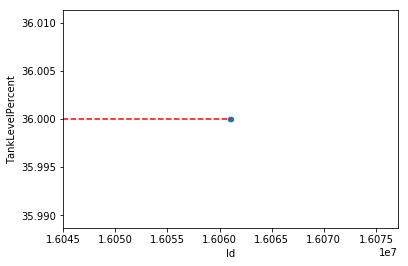

In [137]:
df_event_level_min.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 16061059],[harmonic_mean_min,harmonic_mean_min], 'r--')
plt.xlim(16061059, 16061059)
plt.show()

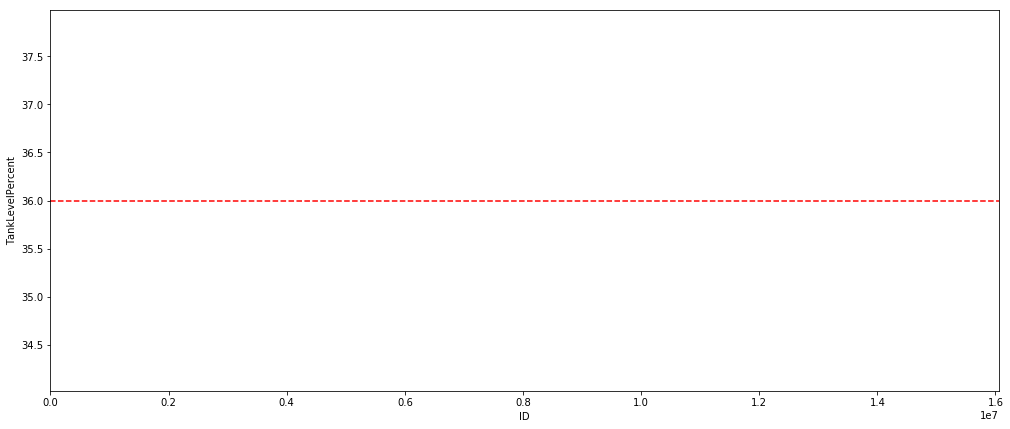

In [150]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_min.Id, df_event_level_min.TankLevelPercent)
_ = plt.plot([0, 16061059],[harmonic_mean_min,harmonic_mean_min], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(0, 16061059)

plt.show();

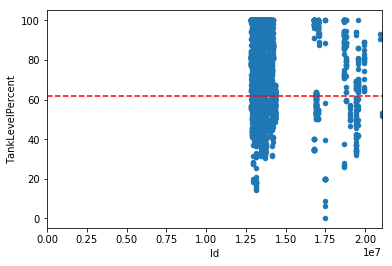

In [154]:
df_event_level_median.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(0, 21055426)
plt.show()

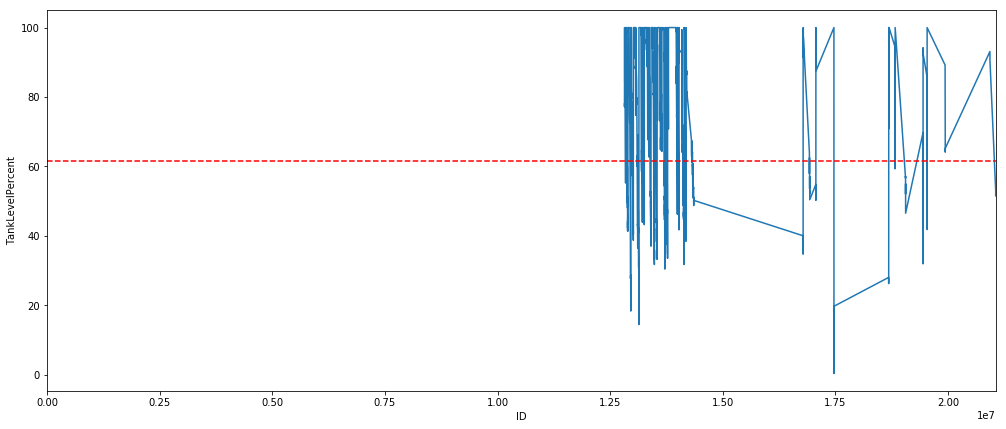

In [155]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_median.Id, df_event_level_median.TankLevelPercent)
_ = plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(0, 21055426)

plt.show();

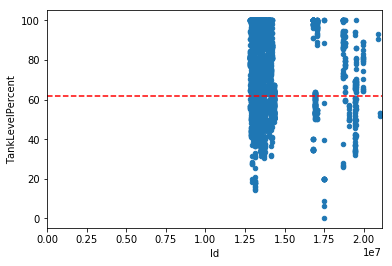

In [156]:
df_event_level_median.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21142685],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(0, 21142685)
plt.show()

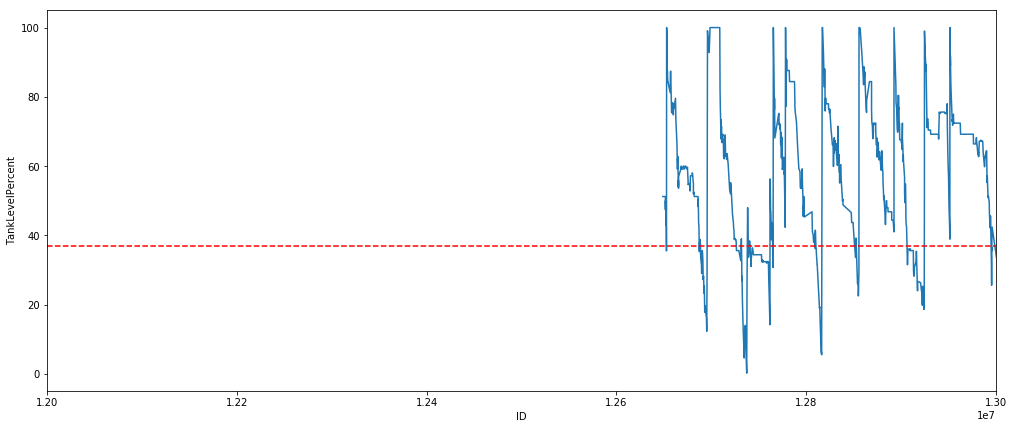

In [160]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_max.Id, df_event_level_max.TankLevelPercent)
_ = plt.plot([12000000, 13000000],[harmonic_mean_max,harmonic_mean_max], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(12000000, 13000000)

plt.show();